In [3]:
from datetime import datetime
import gsw
from matplotlib.dates import DateFormatter,HourLocator, YearLocator, MonthLocator, DayLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import xarray as xr

from ONCToolbox import ONCToolbox

In [4]:
loc_code = 'CBYIP'
resample_type = 'avg'
resample_period = 86400
out_as = 'xarray'
add_metadata = True

# Instantiate ONCToolbox class.
onct = ONCToolbox(timeout = 60 * 30)

# Year range to obtain data for.
years = range(2012, datetime.now().year + 1)

## Obtain Ice Profiler Data

In [5]:
dss = []
for year in years:
    date_from = datetime(year,1,1,0,0,0,0)
    date_to = datetime(year,12,31,23,59,59,999999)
    try: # Use try-catch because we are too lazy to look up info using deployments endpoint.
        _ds = onct.get_clean_data(location_code=loc_code,
                                  device_category_code='ICEPROFILER',
                                  resample_type=resample_type,
                                  resample_period = resample_period,
                                  date_from=date_from,
                                  date_to=date_to,
                                  out_as=out_as,
                                  add_metadata=add_metadata)
    except:
        continue
    _ds = _ds.drop_vars([dv for dv in _ds.data_vars if dv.startswith('qaqc_flag')],errors = 'ignore')
    dss.append(_ds)
icepro = xr.concat(dss, dim = 'time',combine_attrs = 'drop_conflicts', join = 'outer', data_vars='all')
icepro = icepro.drop_duplicates(dim = 'time', keep = 'first')
icepro = icepro.sortby('time')

## Obtain TS Data 2012-2013

In [6]:
date_from = datetime(2012,1,1,0,0,0,0)
date_to = datetime(2015,12,31,23,59,59,999999)

_ds = onct.get_clean_data(location_code=loc_code,
                          device_category_code='WETLABS_WQM',
                          resample_type=resample_type,
                          resample_period = resample_period,
                          date_from=date_from,
                          date_to=date_to,
                          out_as=out_as,
                          add_metadata=add_metadata)
_ds = _ds.drop_vars([dv for dv in _ds.data_vars if dv.startswith('qaqc_flag')],errors = 'ignore')

## Only keep variables that will help compute sea water density.
_ds = _ds[['practical_salinity','temperature','pressure','conductivity']]

# Rename variables to CF-compliant names so there are no conflicts when merging with ice profiler data.
_ds = _ds.rename({'conductivity': 'sea_water_electrical_conductivity',
                'temperature': 'sea_water_temperature',
                'practical_salinity': 'sea_water_practical_salinity',
                'pressure': 'sea_water_pressure'})

# Compute absolute salinity. Lat/lon are stored as attributes of the dataset, hence the 'add_metadata' kwarg in the get_clean_data() call.
sa = gsw.SA_from_SP(_ds.sea_water_practical_salinity, _ds.sea_water_pressure, _ds.attrs['lon'], _ds.attrs['lat'])

# Compute conservative temperature.
ct = gsw.CT_from_t(sa, _ds.sea_water_temperature, _ds.sea_water_pressure)

# Compute density and spiciness.
_ds['sea_water_density'] = gsw.density.rho(sa, ct, _ds.sea_water_pressure)
_ds['spiciness0'] = gsw.spiciness0(sa, ct)

wqm = _ds

## Obtain CTD Data 2014-Present

In [7]:
dss = []
for year in years:
    date_from = datetime(year,1,1,0,0,0,0)
    date_to = datetime(year,12,31,23,59,59,999999)
    try: # Use try-catch because we are too lazy to look up info using deployments endpoint.
        _ds = onct.get_clean_data(location_code=loc_code,
                                  device_category_code='CTD',
                                  resample_type=resample_type,
                                  resample_period = resample_period,
                                  date_from=date_from,
                                  date_to=date_to,
                                  out_as=out_as,
                                  add_metadata=add_metadata)
    except:
        continue
    _ds = _ds.drop_vars([dv for dv in _ds.data_vars if dv.startswith('qaqc_flag')],errors = 'ignore')

    # Remove old variables that can be recomputed later.
    _ds = _ds.drop_vars(['sigma-t','sigma-theta_0_dbar','sound_speed','density'], errors = 'ignore')

    # Rename variables to CF-compliant names so there are no conflicts when merging with ice profiler data.
    _ds = _ds.rename({'conductivity': 'sea_water_electrical_conductivity',
                    'temperature': 'sea_water_temperature',
                    'practical_salinity': 'sea_water_practical_salinity',
                    'pressure': 'sea_water_pressure'})

    # Compute absolute salinity. Lat/lon are stored as attributes of the dataset, hence the 'add_metadata' kwarg in the get_clean_data() call.
    sa = gsw.SA_from_SP(_ds.sea_water_practical_salinity, _ds.sea_water_pressure, _ds.attrs['lon'], _ds.attrs['lat'])

    # Compute conservative temperature.
    ct = gsw.CT_from_t(sa, _ds.sea_water_temperature, _ds.sea_water_pressure)

    # Compute density and spiciness.
    _ds['sea_water_density'] = gsw.density.rho(sa, ct, _ds.sea_water_pressure)
    _ds['spiciness0'] = gsw.spiciness0(sa, ct)

    dss.append(_ds)
ctd = xr.concat(dss, dim = 'time',combine_attrs = 'drop_conflicts', join = 'outer', data_vars='all')
ctd = ctd.drop_duplicates(dim = 'time', keep = 'first')
ctd = ctd.sortby('time')

In [8]:
combo = xr.combine_by_coords([icepro, ctd, wqm], combine_attrs='drop_conflicts', join='outer', data_vars = 'all', compat = 'no_conflicts')
combo = combo.dropna(dim = 'time', how = 'all')

In [9]:
local_ice_bulk_density = 917
combo['ice_thickness'] = combo.ice_draft_corrected * (combo.sea_water_density/local_ice_bulk_density)

In [9]:
def circular_rolling_mean(da: xr.DataArray,
                          half_window_width: int) -> xr.DataArray:
    """
    This function allows for the rolling smoothing of the beginning and end of a climatology or threshold dataset,
    which might otherwise be unsmoothed. Higher level wrapper users will rarely call this function directly.

    Pitfalls: This function really only works if the input climatology/threshold data has a full year of data
    and no significant gaps between ends. If only a part of a climatology dataset is provided (e.g. dayofyear 250-350),
    then this function will inappropriately smooth the original dataset with the prepended and appended data.
    If a subset of the climatology is needed, it is recommended that you subset after circular smoothing.

    :param da: A dataset that represents a climatology or threshold dataset with a dayofyear coordinate.
    :param half_window_width: The number of days to include on either side of the central day for smoothing.
    :return: A smoothed dataset with the same dayofyear values as the original dataset.
    """

    # Create a new dataset which can be prepended to the original for "circular" smoothing.
    pre = da.copy(deep=True)
    pre['dayofyear'] = da.dayofyear.min() - da.dayofyear
    pre = pre.sortby('dayofyear')

    # Create a new dataset which can be appended to the original data for "circular" smoothing.
    post = da.copy(deep=True)
    post['dayofyear'] = da.dayofyear.max() + da.dayofyear
    post = post.sortby('dayofyear')

    # Combine the original data with the prepended and appended data.
    circ = xr.combine_by_coords([pre, da, post])

    # Smooth the data with a rolling mean using the half window width.
    rda = circ.rolling({'dayofyear': 2 * half_window_width + 1}, center=True).mean(skipna=True)
    rda = rda.sel(dayofyear=da.dayofyear)  # Select the original dayofyear values for return.
    rda = rda[da.name]  # Why does it become a dataset?
    return rda

def build_daily_climatology(data: xr.DataArray,
                            half_window_width: int = 5,
                            use_circular: bool = True,
                            reference_begin_datetime: datetime = datetime(2012,1,1),
                            reference_end_datetime: datetime | None= None ,
                            reset_to_input_time: bool = False) -> xr.DataArray:
    """
    Build a daily climatology from a reference period. The climatology is calculated on a 366 day year.
    :param temperature: The input temperature DataArray.
    :param half_window_width: The window half width for smoothing the climatology.
    :param use_circular: Setting to True will wrap the climatology during smoothing.
    :param reset_to_input_time: If True, the output climatology will be mapped to the time
        coordinates of the original input dataset. At the moment this is only intended functionality
        for Fixed Baseline analysis.
    :return: An xr.DataArray representing the daily climatology.
    """

    temperature = data.sel(time=slice(reference_begin_datetime,reference_end_datetime))
    cda = temperature.groupby('time.dayofyear', restore_coord_dims=True).mean(skipna=True)

    if use_circular is True:
        rcda = circular_rolling_mean(cda, half_window_width)
    else:
        rcda = cda.rolling({'dayofyear': 2 * half_window_width + 1}, center=True).mean(skipna=True)
        rcda = rcda.sel(dayofyear=cda.dayofyear)  # Select the original dayofyear values for return.

    # Reset the time coordinate to the original input time for use in shifting or detrended baselines.
    if reset_to_input_time is True:
        reset_bins = []
        years = np.unique(temperature.time.dt.year)
        for year in years:
            _aligned_rcda = rcda.copy(deep = True)
            _aligned_rcda['time'] = (['dayofyear'], [datetime.strptime(f"{year}-{int(dt)}", '%Y-%j')
                                                     for dt in _aligned_rcda.dayofyear.values.tolist()])
            _aligned_rcda = _aligned_rcda.swap_dims({'dayofyear': 'time'})
            _aligned_rcda = _aligned_rcda.drop_duplicates(dim = 'time', keep = 'last')
            reset_bins.append(_aligned_rcda)
        rcda = xr.combine_by_coords(reset_bins)
        rcda = rcda[temperature.name]  # Why does it become a dataset?


    # # Update attributes.
    # rcda.name = f"climatology_{rcda.name}"
    # rcda = assign_static_attributes(rcda)
    # rcda.attrs['climatology_method'] = 'mean'
    # rcda.attrs['climatology_half_window_smooth'] = half_window_width
    # rcda.attrs['climatology_reference_begin'] = temperature.time.min().dt.strftime('%Y-%m-%d').values
    # rcda.attrs['climatology_reference_end'] = temperature.time.max().dt.strftime('%Y-%m-%d').values
    # rcda.attrs['climatology_reference_period'] = int((temperature.time.max().values -
    #                                                   temperature.time.min().values).astype('timedelta64[Y]')) + 1
    return rcda


In [11]:
clim = build_daily_climatology(combo.ice_thickness, half_window_width=5, use_circular = True)

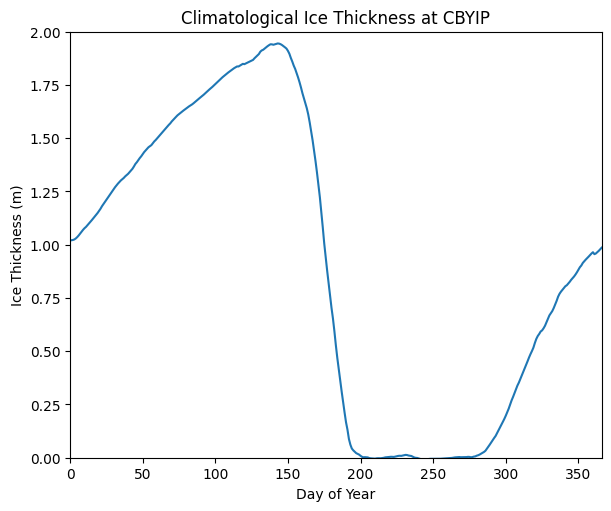

In [12]:
fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)
ax.plot(clim.dayofyear, clim)

ax.set_xlim(0,366)
ax.set_ylim(0, 2)
ax.set_ylabel('Ice Thickness (m)')
ax.set_xlabel('Day of Year')
ax.set_title('Climatological Ice Thickness at CBYIP')
plt.savefig('../figures/ice_thickness_example.jpg', dpi = 300)